<a href="https://colab.research.google.com/github/Geogabriel/gmt/blob/master/04-LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

To enter the rich world of artificial neural networks, the primary tool in the arsenal of machine learning, we will start by analyzing *logistic regression*.

Let us recall the task of classifying lithofacies from well-log data. We will simplify it by looking at only a single log.

In [1]:
import pandas as pd

# load data from CSV file
url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/facies_vectors.csv'
data = pd.read_csv(url)
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


First, prepare data for training by setting aside the SHANKLE well and removing wells without PE logs.

In [2]:
# Reserve SHAKLE well for testing
shankle = data['Well Name'] == 'SHANKLE'
data_shankle = data[shankle]
data_noshankle = data[~shankle]

# Remove wells without PE logs
haspe = ~data_noshankle['PE'].isna()
data_train = data_noshankle[haspe]

Recall lithofacies for classification.

|Code |Label| Color | Facies Name | Adjacent |
|-----|-----|:-------:|:-------------|----------|
|1 | SS | <span style="color:#F4D03F">yellow</span> | Nonmarine sandstone | 2 |
|2 |CSiS| <span style="color:#F5B041">light orange</span> | Nonmarine coarse siltstone | 1,3 |
|3 |FSiS| <span style="color:#DC7633">orange</span> | Nonmarine fine siltstone  | 2 |
|4 |SiSh| <span style="color:#6E2C00">brown</span> | Marine siltstone and shale | 5 |
|5 |MS| <span style="color:#1B4F72">dark blue</span> | Mudstone (limestone) | 4,6 |
|6 |WS| <span style="color:#2E86C1">blue</span> | Wackestone (limestone) | 5,7 |
|7 |D| <span style="color:#AED6F1">light blue</span> | Dolomite | 6,8 |
|8 |PS| <span style="color:#A569BD">purple</span> | Packstone-grainstone (limestone) | 6,7,9 |
|9 |BS| <span style="color:#196F3D">green</span> | Phylloid-algal bafflestone (limestone) | 7,8 |

In [3]:
# Define codes and colors

facies_codes = ['SS', 'CSiS', 'FSiS', 'SiSh',
                'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041', '#DC7633', '#6E2C00',
                 '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

Recall that the PE log can be indicative of mineralogy. Let us see what information about lithofacies it can provide us by itself.

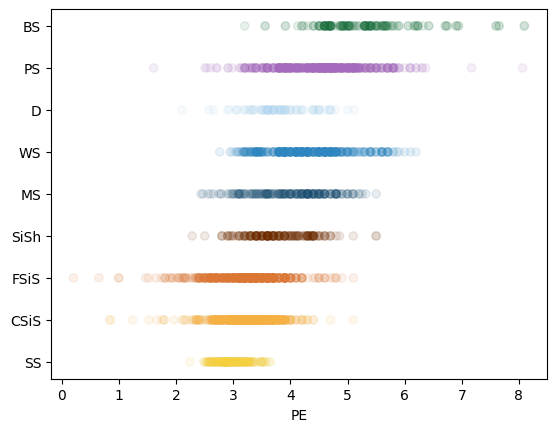

In [4]:
import matplotlib.pyplot as plt
colors = [facies_colors[f-1] for f in data_train.Facies]
plt.scatter(data_train.PE, data_train.Facies, c=colors, alpha=0.1)
plt.xlabel('PE')
plt.yticks(ticks=range(1, 10), labels=facies_codes)
plt.show()

We can observe a lot of overlap between different facies. Let us simplify the problem further. Suppose we only want to classify the bafflestone.

![](https://www.beg.utexas.edu/lmod/_IOL-CM01/graphics/Dunham.jpg)
Dunham, R. J., 1962, Classification of carbonate rocks according to depositional texture, in Ham, W. E., ed., Classification of Carbonate Rocks: AAPG Memoir 1, p. 108–121. <br>
https://www.beg.utexas.edu/lmod/_IOL-CM01/cm01-step03.htm

![](https://upload.wikimedia.org/wikipedia/commons/7/76/DunhamBafflestone.jpg)
https://en.wikipedia.org/wiki/Bafflestone

In [5]:
import numpy as np

# add a bafflestone indicator: column with ones and zeros
data_train = data_train.copy()
data_train['BS'] = np.where(data_train['Facies'] == 9, 1, 0)

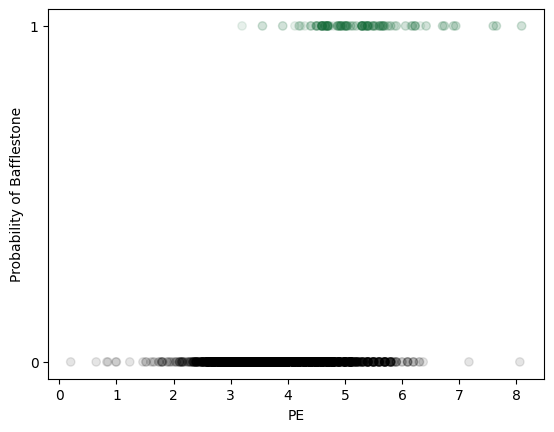

In [6]:
colors = [['#000000', '#196F3D'][f] for f in data_train.BS]
plt.scatter(data_train.PE, data_train.BS, c=colors, alpha=0.1)
plt.xlabel('PE')
plt.yticks(ticks=[0, 1])
plt.ylabel('Probability of Bafflestone')
plt.show()

We can still see an overlap, but it is clear that large values of PE are more likely to indicate the bafflestone. Where do we draw the line to get the best indicator?

Logistic regression can answer this question.

## Applying Logistic Regression

We proceed similarly as before.

1. Divide the dataset for training and validation.

In [7]:
# select dependent and independent features
x = data_train['PE']
x = x.values.reshape(-1, 1)  # the input must be two-dimensional
y = data_train['BS']

In [8]:
# divide for training and validation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=2025)

print('Training: ', x_train.shape, y_train.shape)
print('Testing: ', x_test.shape, y_test.shape)

Training:  (2226, 1) (2226,)
Testing:  (557, 1) (557,)


2. Define and train a prediction model.

In [9]:
# define a model
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight='balanced')

# train model
LR.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

The parameter <code>class_weight='balanced'</code> is needed, because we have a lot more instances of BS=0 (no bafflestone) than BS=1. There are more adjustable parameters in <code>LogisticRegression</code> that we will discuss below.

3. Check the confusion matrix.

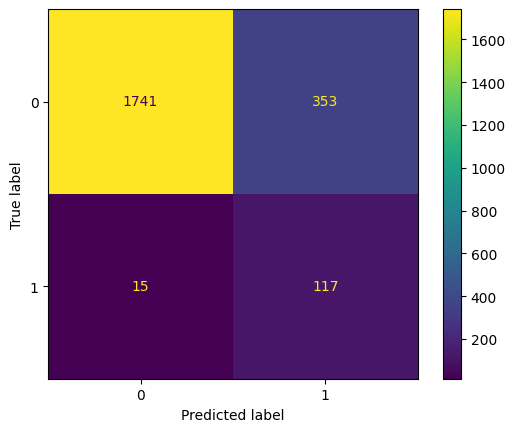

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = LR.predict(x_train)
cm = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

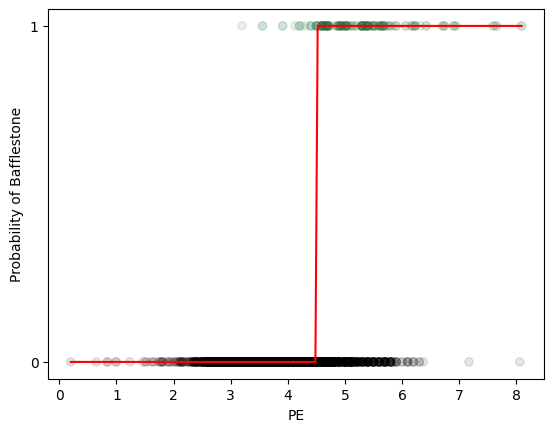

In [11]:
bs_color = [['#000000', '#196F3D'][f] for f in data_train.BS]
plt.scatter(data_train.PE, data_train.BS, c=bs_color, alpha=0.1)
PE = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)
plt.plot(PE, LR.predict(PE), color='red')
plt.xlabel('PE')
plt.yticks(ticks=[0, 1])
plt.ylabel('Probability of Bafflestone')
plt.show()

## How does it work?

In the classic linear regression, we fit a line $y(x) = a+b\,x$ to the data points to estimate parameters $a$ and $b$.

Similar work is done in logistic regression; we only want the output not to cover the whole range of values but to correspond to the probability of bafflestone and thus to be contained in the range from 0 to 1. This is achieved by applying a non-linear transformation

$$y(x) = s(a+b\,x)\;,$$

where $s(z)$ is a function that maps the infinite range of values to the range of probabilities.

The classic choice is the sigmoid function (also known as the logistic function):

$$s(z) = \displaystyle \frac{1}{1 + e^{-z}}\;.$$

Note that $s(0)=0.5$.

For large positive values of $z$, $s(z)$ approaches 1.

For large negative values of $z$, $s(z)$ approaches 0.

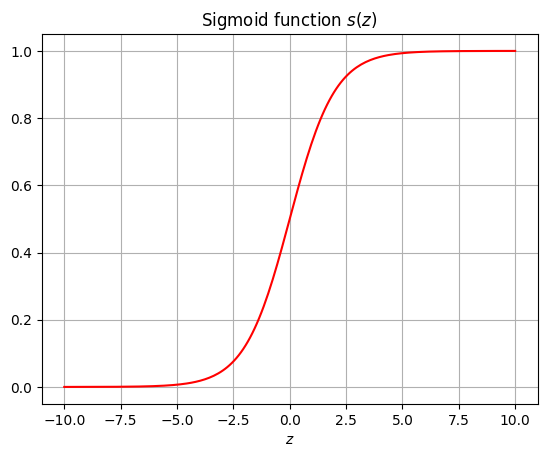

In [12]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


z = np.linspace(-10, 10, 200)
plt.plot(z, sigmoid(z), color='red')
plt.grid(True)
plt.xlabel('$z$')
plt.title('Sigmoid function $s(z)$')
plt.show()

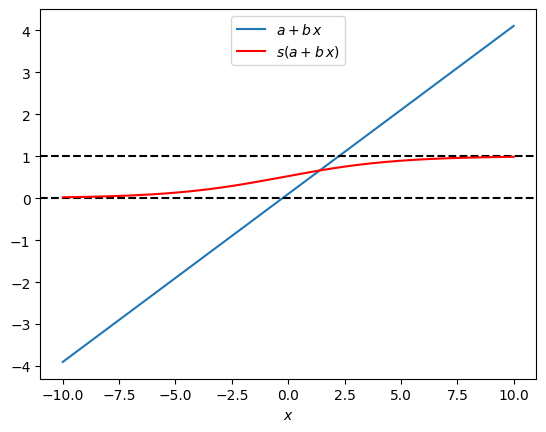

In [13]:
x = np.linspace(-10, 10, 200)
y = 0.1+0.4*x
plt.plot(x, y, label='$a+b\,x$')
plt.axhline(y=0, color='k', linestyle='--')
plt.axhline(y=1, color='k', linestyle='--')
plt.plot(x, sigmoid(y), color='red', label='$s(a+b\,x)$')
plt.xlabel('$x$')
plt.legend(loc='upper center')
plt.show()

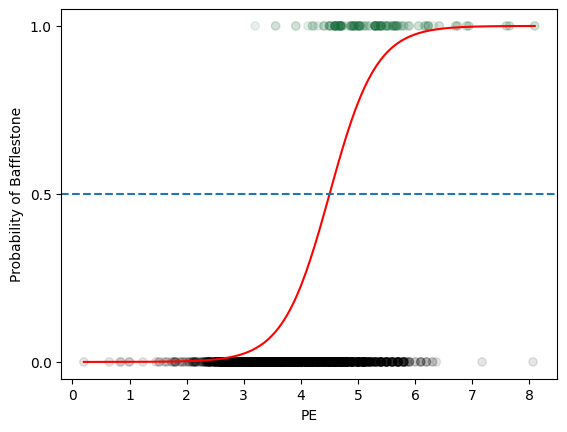

In [14]:
# extract model coefficients
a = LR.intercept_[0]
b = LR.coef_[0][0]

plt.scatter(data_train.PE, data_train.BS, c=bs_color, alpha=0.1)
PE = np.linspace(x_train.min(), x_train.max(), 200)
plt.plot(PE, sigmoid(a+b*PE), color='red')
plt.axhline(y=0.5, linestyle='--')
plt.xlabel('PE')
plt.yticks(ticks=[0, 0.5, 1])
plt.ylabel('Probability of Bafflestone')
plt.show()

Introducing logistic mapping is not the only change. We also need to change how we evaluate the prediction error to estimate the model coefficients ($a$ and $b$).

In classic regression, the misfit is defined by the least-squares metric

$$E_{R}(a,b) = \displaystyle \frac{1}{N}\,\sum_{n=1}^{N} (a+b\,x_n - y_n)^2\;.$$

It is not appropriate to use the same metric when fitting probabilities.

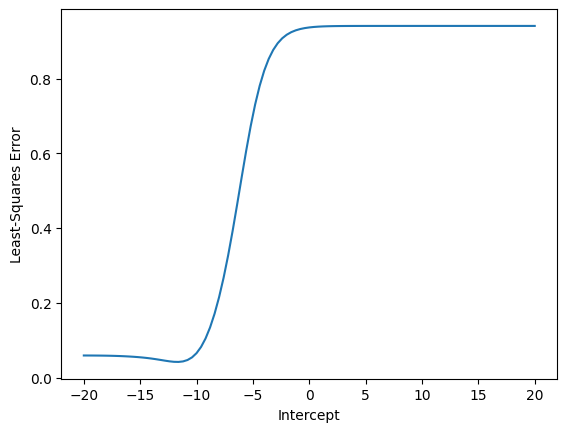

In [15]:
from sklearn.metrics import mean_squared_error


def least_squares(a, b):
    return mean_squared_error(sigmoid(a+b*x_train), y_train)


a = np.linspace(-20, 20, 101)
error = np.vectorize(least_squares)(a, 2)
plt.plot(a, error)
plt.xlabel('Intercept')
plt.ylabel('Least-Squares Error')
plt.show()

The common error function for logistic regression is *cross-entropy*:

$$E_{LR}(a,b) = \displaystyle - \frac{1}{N}\,\sum_{n=1}^{N} \left[y_n\,\log(p_n) + (1-y_n)\,\log(1-p_n)\right]\;,$$

where $p_n = s(a + b\,x_n)$.

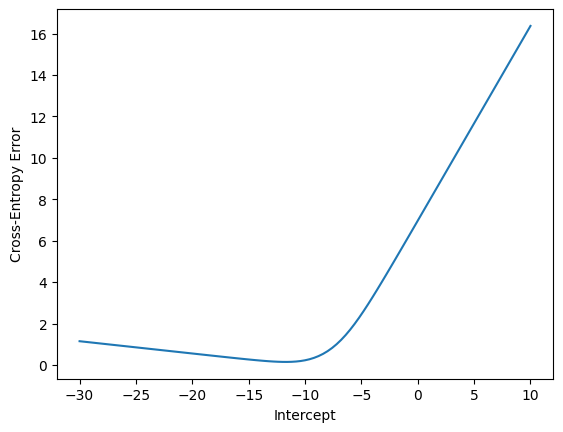

In [16]:
from sklearn.metrics import log_loss

def cross_entropy(a, b):
    prob = sigmoid(a+b*x_train)
    y_pred = np.concatenate((1-prob, prob), axis=1)
    return log_loss(y_train, y_pred)

a = np.linspace(-30, 10, 101)
error = np.vectorize(cross_entropy)(a, 2)
plt.plot(a, error)
plt.xlabel('Intercept')
plt.ylabel('Cross-Entropy Error')
plt.show()

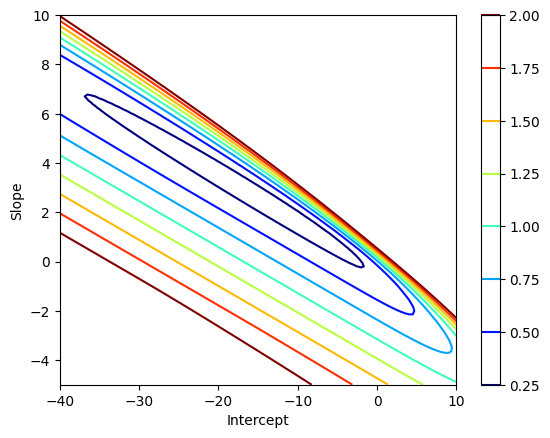

In [17]:
a, b = np.meshgrid(
    np.linspace(-40, 10, 101),
    np.linspace(-5, 10, 101))
error = np.vectorize(cross_entropy)(a, b)

# plot surface
plt.contour(a, b, error, np.arange(0.25, 2.25, 0.25), cmap='jet')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.colorbar()
plt.show()

The cross-entropy objective function is convex with a global minimum. Although we don't have the luxury of being able to find the minimum analytically, we can estimate it using iterative gradient descent. Luckily, the gradient can be computed analytically.

Using the chain rule and algebraic simplifications,

$$s'(z) = \displaystyle - \frac{e^{-z}}{1+e^{-z}} = s(z)\,\left[1-s(z)\right]\;,$$

$$\displaystyle \frac{\partial E_{LR}(a,b)}{\partial a} = \frac{1}{N}\,\sum_{n=1}^{N} (p_n-y_n)\;,$$
$$\displaystyle \frac{\partial E_{LR}(a,b)}{\partial b} = \frac{1}{N}\,\sum_{n=1}^{N} (p_n-y_n)\,x_n\;.$$

The default optimization method for logistic regression in <code>sklearn</code> is L-BFGS (limited memory Broyden–Fletcher–Goldfarb–Shanno algorithm). There are other options.

https://users.iems.northwestern.edu/~nocedal/lbfgsb.html

By default, the objective function is also modified to include regularization.

In [18]:
from sklearn.linear_model import LogisticRegression

LogisticRegression?

## Task 1

<div class="alert alert-block alert-info">
When we used parameter <code>class_weight='balanced'</code> in the logistic regression function, it normalized the objective function to account for the disparity in the occurrence of different classes.</div>

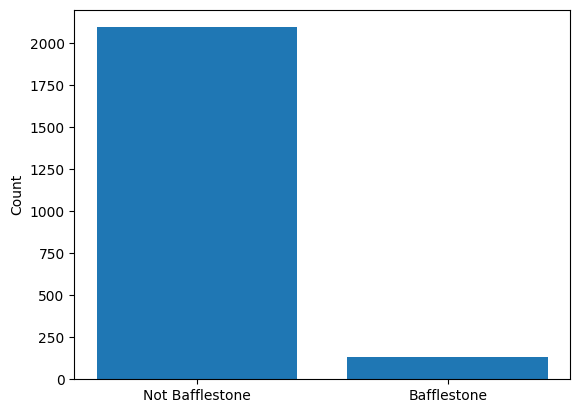

In [19]:
# bincount counts occurrence
plt.bar([0, 1], np.bincount(y_train))
plt.xticks([0, 1], ['Not Bafflestone', 'Bafflestone'])
plt.ylabel('Count')
plt.show()

Instead of assigning equal weight to different samples, we can adjust the weights in inverse proportion to occurrence:

$$E_{LR}(a,b) = \displaystyle - \frac{1}{N}\,\sum_{n=1}^{N} {\color{red}{\alpha_n}}\left[y_n\,\log(p_n) + (1-y_n)\,\log(1-p_n)\right]\;,$$

The weights $\alpha_n$ to assign to each sample can be computed as follows:

In [20]:
from sklearn.utils.class_weight import compute_sample_weight

weights = compute_sample_weight(class_weight='balanced',
                                y=y_train)

**Your task**:

1. Look up the definition of <code>log_loss</code> function, find the parameter for the sample weights, and insert it in the definition of <code>cross_entropy</code> function above.
2. Regenerate the plots for the cross-entropy objective function.
3. Mark the intercept and the slope found by logistic regression with a dot in the contour plot.

In [42]:
def cross_entropy(a, b):
    prob = sigmoid(a+b*x_train)
    y_pred = np.concatenate((1-prob, prob), axis=1)
    return log_loss(y_train, y_pred, sample_weight=weights)

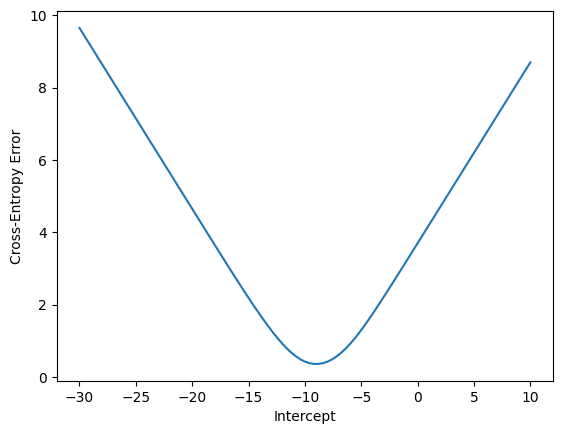

In [43]:
a = np.linspace(-30, 10, 101)
error = np.vectorize(cross_entropy)(a, 2)
plt.plot(a, error)
plt.xlabel('Intercept')
plt.ylabel('Cross-Entropy Error')
plt.show()

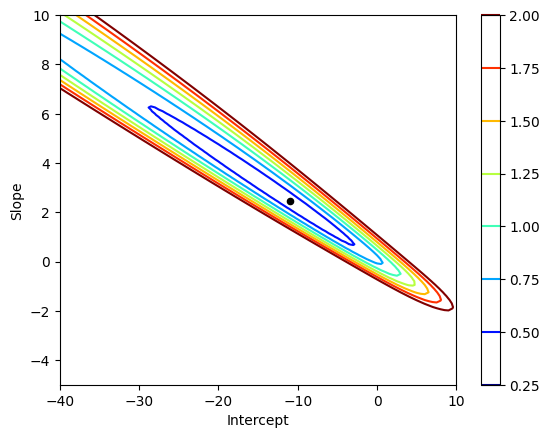

In [44]:
a, b = np.meshgrid(
    np.linspace(-40, 10, 101),
    np.linspace(-5, 10, 101))
error = np.vectorize(cross_entropy)(a, b)

# plot surface
plt.contour(a, b, error, np.arange(0.25, 2.25, 0.25), cmap='jet')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.colorbar()
plt.scatter(LR.intercept_[0], LR.coef_[0][0], c='black', s=20)
plt.show()

## Logistic regression in multiple dimensions

Similarly to classic regression, logistic regression can be easily extended to multiple dimensions or multiple output labels.

In [21]:
# select two logs

x2 = data_train.loc[:, ['GR', 'PHIND']]
y2 = data_train.Facies

# split for testing and training
x2_train, x2_test, y2_train, y2_test = \
    train_test_split(x2, y2, test_size=0.2, random_state=2025)

In [22]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

# fit only on training data to avoid bias
scaler.fit(x2_train)
x2_train = scaler.transform(x2_train)
# apply same transformation to test data
x2_test = scaler.transform(x2_test)

# define model for multiple-class classification
LR2 = LogisticRegression(multi_class='multinomial')

# train model
LR2.fit(x2_train, y2_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial')

In [23]:
import matplotlib.colors as colors
cmap = colors.ListedColormap(facies_colors)
color = [facies_colors[f-1] for f in y2_train]

In [24]:
def plot_regions(cls):
    'plot regions in 2-D space as defined by classifier'
    # create 100 x 100 grid
    G = np.linspace(x2_train[:, 0].min(), x2_train[:, 0].max(), 100)
    R = np.linspace(x2_train[:, 0].min(), x2_train[:, 1].max(), 100)
    G, R = np.meshgrid(G, R)
    # predict facies for every point
    grid = np.array([G.ravel(), R.ravel()]).T
    F = cls.predict(grid).reshape(G.shape)

    # overlay map and scatter plot
    cf = plt.contourf(G, R, F, np.arange(0.5, 10.5), cmap=cmap, alpha=0.9)
    plt.scatter(x2_train[:, 0], x2_train[:, 1], c=color, edgecolors='k')
    plt.axis([G.min(), G.max(), R.min(), R.max()])
    cbar = plt.colorbar(cf, ticks=range(1, 10))
    cbar.ax.set_yticklabels(facies_codes)
    plt.xlabel('Normalized gamma ray')
    plt.ylabel('Normalized neutron-density porosity')
    plt.show()

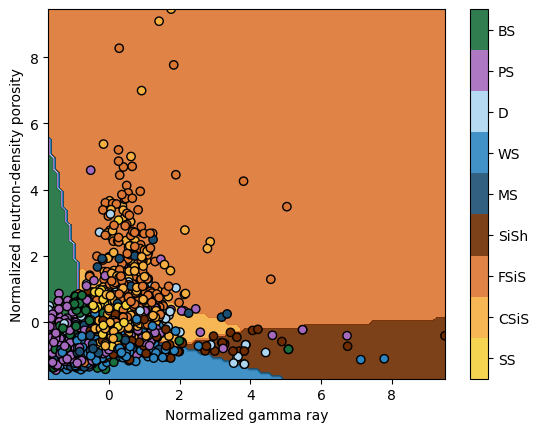

In [25]:
plot_regions(LR2)

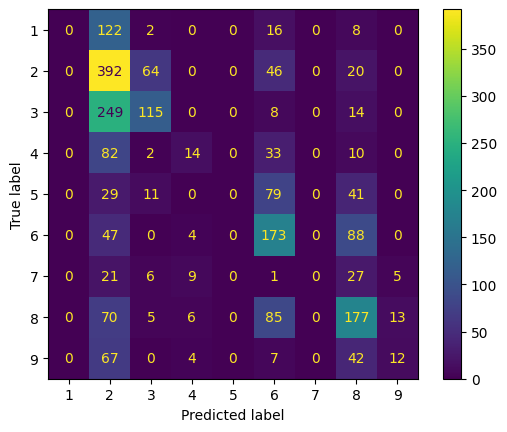

In [26]:
y2_train_pred = LR2.predict(x2_train)

cm2 = ConfusionMatrixDisplay.from_predictions(y2_train, y2_train_pred)

## Task 2

<div class="alert alert-block alert-info">
Apply logistic regression for facies classification using all available logs and compare the result with that from one of the previously tested classifiers (<code>KNeighborsClassifier</code>, <code>SVC</code>, or <code>DecisionTreeClassifier</code>).</div>

## From Logistic Regression to Artificial Neural Networks

Let us slightly modify the problem and use the PE log to classify mud-related facies (Marine siltstone and shale, Mudstone, and Wackestone).

In [27]:
# add a column with an array of ones and zeros
data_train = data_train.copy()
data_train['Mud'] = np.where((data_train['Facies'] > 3) &
                             (data_train['Facies'] < 7), 1, 0)

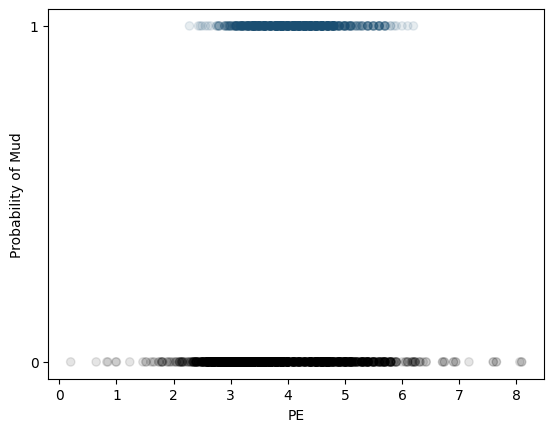

In [28]:
mud_color = [['#000000', '#1B4F72'][f] for f in data_train.Mud]
plt.scatter(data_train.PE, data_train.Mud, c=mud_color, alpha=0.1)
plt.xlabel('PE')
plt.yticks(ticks=[0, 1])
plt.ylabel('Probability of Mud')
plt.show()

There is a lot of overlap, but even if we neglect it, there is no particular place to draw a line because the PE values for "Mud" are distributed within an interval. We need at least two lines to separate this interval from smaller and higher values.

Logistic regression cannot help in this situation. We will extend it using a simple version of an *artificial neural network*.

First, let us prepare the data.

In [29]:
# select dependent and independent features
x1 = data_train.loc[:, ['PE']]
y1 = data_train['Mud']

x1_train, x1_test, \
    y1_train, y1_test = \
    train_test_split(x1, y1, test_size=0.2, random_state=2025)

scaler = preprocessing.StandardScaler()

# fit only on training data to avoid bias
scaler.fit(x1_train)
x1_train = scaler.transform(x1_train)
# apply same transformation to test data
x1_test = scaler.transform(x1_test)

An appropriate tool from the <code>sklearn</code> package is <code>MLPClassifier</code>. MLP stands for Multi-Layer Perceptron.

In [30]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='lbfgs', random_state=1,
                   activation='logistic', hidden_layer_sizes=(2,))
NN.fit(x1_train, y1_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(2,), random_state=1,
              solver='lbfgs')

In [31]:
MLPClassifier?

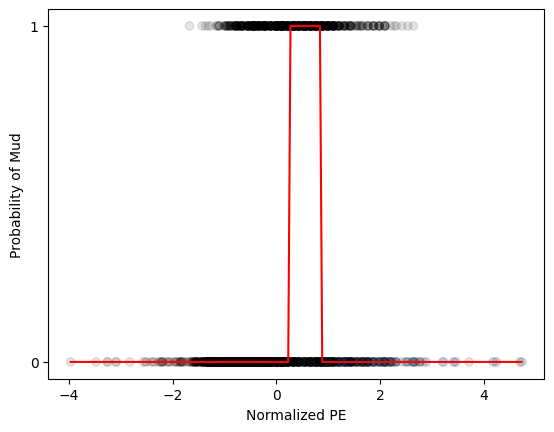

In [32]:
mud_color = [['#000000', '#1B4F72'][f] for f in y_train]
plt.scatter(x1_train, y1_train, c=mud_color, alpha=0.1)
PE = np.linspace(x1_train.min(), x1_train.max(), 200).reshape(-1, 1)
plt.plot(PE, NN.predict(PE), color='red')
plt.xlabel('Normalized PE')
plt.yticks(ticks=[0, 1])
plt.ylabel('Probability of Mud')
plt.show()

In [33]:
NN.intercepts_

[array([0.1611005 , 1.92555717]), array([-1.58668336])]

In [34]:
NN.coefs_

[array([[-1.88448242, -2.25692849]]),
 array([[-7.68331768],
        [ 6.08052102]])]

## How does it work?

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Blausen_0657_MultipolarNeuron.png/800px-Blausen_0657_MultipolarNeuron.png)

The name "neural network" refers to a simplified model of how information is transmitted through neurons in the brain.

![](https://upload.wikimedia.org/wikipedia/commons/1/1d/Neural_network_example.png)

* https://en.wikipedia.org/wiki/Neural_network

In our case, we have extended the idea of logistic regression to introduce an additional layer of computation (known as the *hidden layer*).

Recall that, without the hidden layer, the logistic model was
$$y(x) = s(a+b\,x)\;.$$

Now, inside the hidden layer, we create two outputs
$$h_1(x) = s(a_1+b_1\,x)$$

and
$$h_2(x) = s(a_2+b_2\,x)\;.$$

In the *output layer*, we treat these outputs as inputs and combine them as follows:

$$y(x) = s\left(a_3 + b_{31}\,h_1(x) + b_{32}\,h_2(x)\right)\;.$$

Thus, the number of parameters increases from two ($a$ and $b$) to seven ($a_1$, $b_1$, $a_2$, $b_2$, $a_3$, $b_{31}$, $b_{32}$).

We can compute the gradient of the objection function with respect to all of these parameters and use gradient descent to find the optimal parameter values.

In [35]:
# extract parameters from the neural network
a1 = NN.intercepts_[0][0]
b1 = NN.coefs_[0][0][0]

a2 = NN.intercepts_[0][1]
b2 = NN.coefs_[0][0][1]

# hidden layer
h1 = sigmoid(a1+b1*x1_train)
h2 = sigmoid(a2+b2*x1_train)

# parameters for the output layer
a3 = NN.intercepts_[1][0]
b31 = NN.coefs_[1][0][0]
b32 = NN.coefs_[1][1][0]

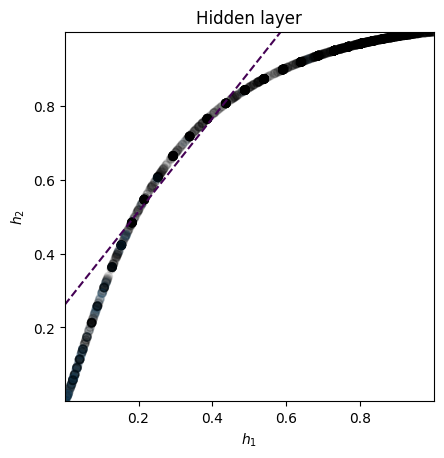

In [36]:
g1, g2 = np.meshgrid(
    np.linspace(h1.min(), h1.max(), 101),
    np.linspace(h2.min(), h2.max(), 101))
g3 = sigmoid(a3+b31*g1+b32*g2)

# plot surface
plt.scatter(h1, h2, c=mud_color, alpha=0.1)
plt.contour(g1, g2, g3, [0.5], linestyles='--')
plt.xlabel('$h_1$')
plt.ylabel('$h_2$')
plt.gca().set_aspect('equal')
plt.title('Hidden layer')
plt.show()

## Stochastic gradient descent

In a gradient descent method, the parameters (weights) $\mathbf{w}_n$ of a neural network at iteration $n$ are updated according to

$$\mathbf{w}_n = \mathbf{w}_{n-1} - \lambda \nabla_{\mathbf{w}} E\;,$$

where $\nabla_w E$ represents the gradient of the objective function, and $\lambda$ is the *learning rate*. The learning rate is an important parameter. If it is too large, we may step past the desired minimum. If it is too small, we may need to do extra iterations.

The number of parameters in a network can quickly grow by adding hidden layers and increasing the size of the layers. Computing the exact gradient becomes computationally expensive. Because we need the gradient only to make a step toward the minimum, a winning strategy is randomly dividing the training data into *batches* and making iterative steps using the gradient for a batch. This approach is generally known as *stochastic gradient descent*.

In [37]:
# stochastic gradient descent
NN2 = MLPClassifier(solver='sgd', batch_size=10, random_state=2025,
                    learning_rate='constant', learning_rate_init=0.01,
                    activation='logistic', hidden_layer_sizes=(2,))
NN2.fit(x1_train, y1_train)

MLPClassifier(activation='logistic', batch_size=10, hidden_layer_sizes=(2,),
              learning_rate_init=0.01, random_state=2025, solver='sgd')

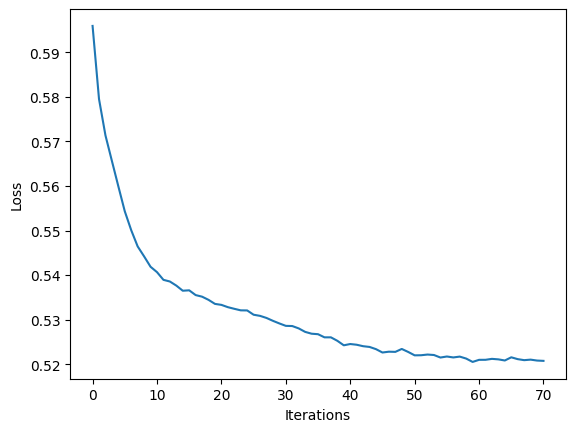

In [38]:
plt.plot(NN2.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

## Task 3

<div class="alert alert-block alert-info">
While we need the logistic (sigmoid) activation function in the output layer to produce probabilities, the activation function in the hidden layer can be different.

Other popular choices include the hyperbolic tangent function, which maps the infinite domain to the range from -1 to 1:

$$\tanh(z) = \displaystyle \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

and ReLU (Rectified Linear Unit), which maps the infinite domain to the positive domain:

$$\mbox{ReLU}(z) = \max(0,z)\;.$$</div>

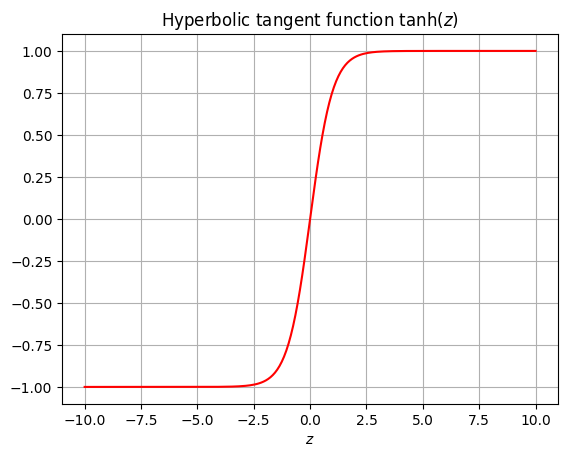

In [39]:
z = np.linspace(-10, 10, 200)
plt.plot(z, np.tanh(z), color='red')
plt.grid(True)
plt.xlabel('$z$')
plt.title('Hyperbolic tangent function $\\tanh(z)$')
plt.show()

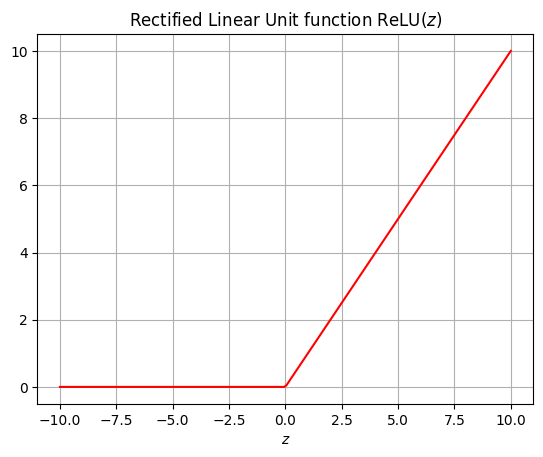

In [40]:
z = np.linspace(-10, 10, 200)
plt.plot(z, np.maximum(z, 0), color='red')
plt.grid(True)
plt.xlabel('$z$')
plt.title('Rectified Linear Unit function ReLU($z$)')
plt.show()

**Your task**:

1. Change the activation function parameter in <code>MLPClassifier</code> to the hyperbolic tangent or ReLU and observe the change in the convergence of stochastic gradient descent.

Another way to accelerate convergence is to use a different optimization method. A popular choice is Adam (Adaptive Moment Estimation).
![](https://miro.medium.com/max/1400/1*47skUygd3tWf3yB9A10QHg.gif)
Kingma, D.P. and Ba, J., 2014. Adam: A method for stochastic optimization. [arXiv preprint](https://arxiv.org/abs/1412.6980)

2. Change the solver parameter in <code>MLPClassifier</code> from SGD to Adam and observe the change in convergence.

In [41]:
MLPClassifier?

## Conclusions

We have accomplished only simplistic experiments so far. Still, they guided us from the simple concept of logistic regression (regression adapted for classification problems) to the idea of artificial neural networks, the primary tool in the arsenal of machine learning.

The key ideas are:
1. Chaining linear operations with non-linear mappings, such as the logistic function (roughly analogous to the function of neurons in the human brain.)
2. Finding an appropriate objective function for classification problems and minimizing it through gradient descent.
3. Extending dimensions and the number of parameters by adding hidden layers in the artificial neural network.
4. Applying stochastic gradient descent and its modifications to increase optimization efficiency.